# Sensor Comparison assisted by EEMD

This script reads data from a field comparison of numerous sensors for soil moisture and matric potential. It uses an Ensemble Empirical Mode Decomposition (EEMD) for spectral recomposition of the recorded signals in order to avoid any assumptions about offset or scaling between the individual time series.

Please refer to the original publication by Jackisch et al. 2018: Soil moisture and matric potential -- what do we measure? in Vadose Zone Journal (doi) for further description.

The notebook is given under GNU GPL3 without any liability. (cc) jackisch@kit.edu 2018

In [1]:
#load required modules
%pylab inline
import pandas as pd
import seaborn as sns
import scipy as sp
sns.set_style('whitegrid', {'grid.linestyle': u'--'})
matplotlib.rc('pdf', fonttype=42)

#Please make sure to have also PyEMD, Scipy, itertools, multiprocessing, sklearn and Palettable installed. 
#They will be loaded later on.

Populating the interactive namespace from numpy and matplotlib


In [44]:
#some color definitions
from palettable.tableau import Tableau_10
from palettable.tableau import Tableau_20
cm_t10 = plt.cm.get_cmap(Tableau_10.mpl_colormap)
cm_t20 = plt.cm.get_cmap(Tableau_20.mpl_colormap)

# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
         (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
         (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
         (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
         (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  

tableau10=tableau20[0::2]

# Read Monitoring Data

In [31]:
#read all in situ monitoring data
T20=pd.read_csv('t20.csv',index_col='TIME')
T20.index=pd.to_datetime(T20.index.values)
Theta20=pd.read_csv('theta20.csv',index_col='date')
Theta20.index=pd.to_datetime(Theta20.index.values)
Psi20=pd.read_csv('psi20.csv',index_col='Timestamp')
Psi20.index=pd.to_datetime(Psi20.index.values)
meteo=pd.read_csv('meteo_jki.csv',index_col='Timestamp')
meteo.index=pd.to_datetime(meteo.index.values)

#dwdR=pd.read_csv('dwdR.csv')
#dwdR.index=pd.to_datetime(dwdR[' MESS_DATUM'].values)
#The meteo data of the German Meteorological Service (DWD) is given in their Climate Data Centre under ftp://ftp-cdc.dwd.de/pub/CDC//observations_germany/climate/hourly 
#Check for station 662 as nearby reference.

In [32]:
#get sensors names from records and remove subset number for grouping later on
Theta20sens=Theta20.columns.values.copy()
for i in np.arange(len(Theta20sens)):
    Theta20sens[i]=Theta20sens[i][:-1]

Psi20sens=Psi20.columns.values.copy()
for i in np.arange(len(Psi20sens)):
    Psi20sens[i]=Psi20sens[i][:-1]
    
T20sens=T20.columns.values.copy()
for i in np.arange(len(T20sens)):
    T20sens[i]=T20sens[i][:-1]


# Lab and in-situ retention curves

Read data from laboratory retention analyses and the monitoring data. Plot retention curves from the records.

In [8]:
#use vanGenuchten module
import vG_conv as vG

#LAB DATA
#parameters
vG_JKI_raw=pd.read_csv('JKI_fieldsamples_retention.csv',skiprows=2469,nrows=7,sep=';')
vG_JKI=pd.DataFrame(vG_JKI_raw.Value.values,index=vG_JKI_raw.Parameter.values).T

#retention series
ku_obs=pd.read_csv('JKI_fieldsamples_retention.csv',skiprows=630,nrows=167,sep=';')
ku_obs['K [m/s]']=10**(ku_obs['log 10 K [cm/d]'])/(100.*86400.)

retention=pd.read_csv('JKI_fieldsamples_retention.csv',skiprows=35,nrows=594,sep=';')

(1.7, 2.9)

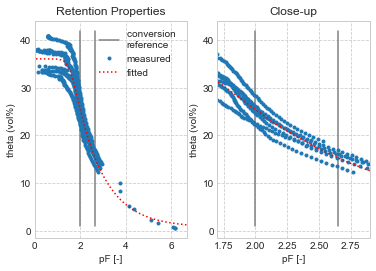

In [9]:
bandx=[2.0,2.65]
sup_dummy=np.arange(0.05,7.,0.05)

thetad=vG.theta_psi((10**sup_dummy)/98.1,vG_JKI.th_s[0]*100.,vG_JKI.th_r[0]*100.,vG_JKI.alpha[0]*100.,vG_JKI.n[0],vG_JKI.m[0])

subplot(121)
plot([bandx[0],bandx[0]],[1,42],'-',c='gray')
plot([bandx[1],bandx[1]],[1,42],'-',c='gray',label='conversion \nreference')

plot(retention.iloc[:,0],retention.iloc[:,1],'.',label='measured')
plot(sup_dummy,thetad,'r:',label='fitted')

legend()
title('Retention Properties')
xlabel('pF [-]')
ylabel('theta (vol%)')
xlim(0,6.7)

subplot(122)
plot([bandx[0],bandx[0]],[1,42],'-',c='gray')
plot([bandx[1],bandx[1]],[1,42],'-',c='gray',label='conversion \nreference')

plot(retention.iloc[:,0],retention.iloc[:,1],'.',label='measured')
plot(sup_dummy,thetad,'r:',label='fitted')

#legend()
title('Close-up')
xlabel('pF [-]')
ylabel('theta (vol%)')
xlim(1.7,2.9)

/Users/cojack/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(4.7,10,'In situ retention pairs\nInitial, homogeneous stage\nTensions mean of tensiometers.')

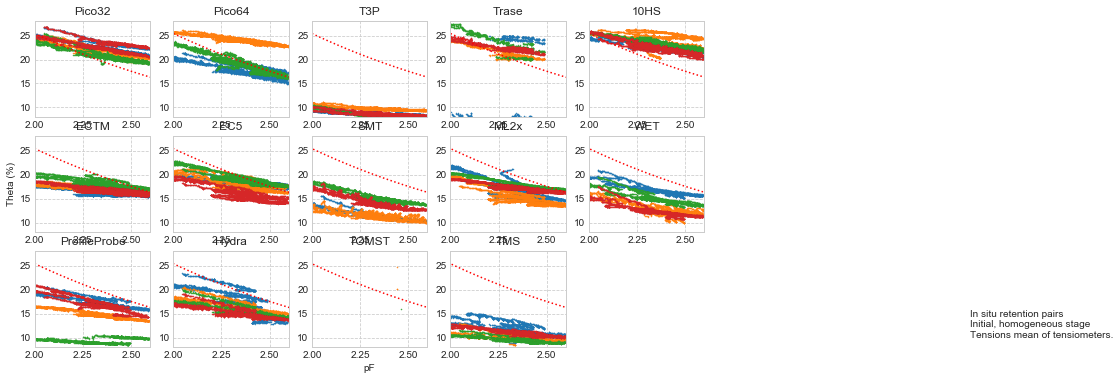

In [33]:
#construct mean tension reference
mean_pF=np.log10(Psi20[['T43','T44','T52','T54','T82','T84']]).mean(axis=1).copy()

#create mask around events
dummy=np.where(abs(np.diff(mean_pF))>0.01)[0]
winx=np.arange(40)-20
idx=[]
for i in dummy:
    idx=np.concatenate((idx,i+winx))
idx=np.concatenate((idx,np.where((mean_pF<2.) | (mean_pF>2.6))[0]))
idx=np.unique(idx)
idx_true=np.setdiff1d(np.arange(len(mean_pF)),idx)

#references
vG_JKI.loc[0]=[0.0254, 5.12, 0.01, 0.347, 0.066, 58.5, 0.5]
dummy_pf = np.arange(100)*(0.6/20)+1.
dummy_theta=vG.theta_psi((10**dummy_pf)/98.1,vG_JKI.th_s[0]*100.,vG_JKI.th_r[0]*100.,vG_JKI.alpha[0]*100.,vG_JKI.n[0],vG_JKI.m[0])

# plot in-situ retention curves
xlimx = (1.,4.)
ylimy = (5., 45.)

xlimx = (2.,2.6)
ylimy = (8.,28.)

figsize(12,6)
subplot(351)
plot(mean_pF.iloc[idx_true],Theta20[['Pico321', 'Pico322', 'Pico323', 'Pico324']].loc[mean_pF.iloc[idx_true].index],'.',ms=1)
plot(dummy_pf,dummy_theta,'r:')
xlim(xlimx)
ylim(ylimy)
title('Pico32')

subplot(352)
plot(mean_pF.iloc[idx_true],Theta20[['Pico641', 'Pico642', 'Pico643']].loc[mean_pF.iloc[idx_true].index],'.',ms=1)
plot(dummy_pf,dummy_theta,'r:')
xlim(xlimx)
ylim(ylimy)
title('Pico64')

subplot(353)
plot(mean_pF.iloc[idx_true],Theta20[['T3P1', 'T3P2', 'T3P3', 'T3P4']].loc[mean_pF.iloc[idx_true].index],'.',ms=1)
plot(dummy_pf,dummy_theta,'r:')
xlim(xlimx)
ylim(ylimy)
title('T3P')

subplot(354)
plot(mean_pF.iloc[idx_true],Theta20[['Trase1','Trase2', 'Trase3', 'Trase4']].loc[mean_pF.iloc[idx_true].index],'.',ms=1)
plot(dummy_pf,dummy_theta,'r:')
xlim(xlimx)
ylim(ylimy)
title('Trase')

subplot(355)
plot(mean_pF.iloc[idx_true],Theta20[['10HS1', '10HS2', '10HS3', '10HS4']].loc[mean_pF.iloc[idx_true].index],'.',ms=1)
plot(dummy_pf,dummy_theta,'r:')
xlim(xlimx)
ylim(ylimy)
title('10HS')

subplot(356)
plot(mean_pF.iloc[idx_true],Theta20[['ECTM1', 'ECTM2', 'ECTM3', 'ECTM4']].loc[mean_pF.iloc[idx_true].index],'.',ms=1)
plot(dummy_pf,dummy_theta,'r:')
xlim(xlimx)
ylim(ylimy)
ylabel('Theta (%)')
title('ECTM')

subplot(357)
plot(mean_pF.iloc[idx_true],Theta20[['EC51', 'EC52', 'EC53', 'EC54']].loc[mean_pF.iloc[idx_true].index],'.',ms=1)
plot(dummy_pf,dummy_theta,'r:')
xlim(xlimx)
ylim(ylimy)
title('EC5')

subplot(358)
plot(mean_pF.iloc[idx_true],Theta20[['SMT1', 'SMT2', 'SMT3', 'SMT4']].loc[mean_pF.iloc[idx_true].index],'.',ms=1)
plot(dummy_pf,dummy_theta,'r:')
xlim(xlimx)
ylim(ylimy)
title('SMT')

subplot(359)
plot(mean_pF.iloc[idx_true],Theta20[['ML2x1', 'ML2x2', 'ML2x3', 'ML2x4']].loc[mean_pF.iloc[idx_true].index],'.',ms=1)
plot(dummy_pf,dummy_theta,'r:')
xlim(xlimx)
ylim(ylimy)
title('ML2x')

subplot(3,5,10)
plot(mean_pF.iloc[idx_true],Theta20[['WET1', 'WET2', 'WET3', 'WET4']].loc[mean_pF.iloc[idx_true].index],'.',ms=1)
plot(dummy_pf,dummy_theta,'r:')
xlim(xlimx)
ylim(ylimy)
title('WET')

subplot(3,5,11)
plot(mean_pF.iloc[idx_true],Theta20[['ProfProbe1', 'ProfProbe2','ProfProbe3', 'ProfProbe4']].loc[mean_pF.iloc[idx_true].index],'.',ms=1)
plot(dummy_pf,dummy_theta,'r:')
xlim(xlimx)
ylim(ylimy)
title('ProfileProbe')

subplot(3,5,12)
plot(mean_pF.iloc[idx_true],Theta20[['Hydra1', 'Hydra2', 'Hydra3', 'Hydra4']].loc[mean_pF.iloc[idx_true].index],'.',ms=1)
plot(dummy_pf,dummy_theta,'r:')
xlim(xlimx)
ylim(ylimy)
title('Hydra')

subplot(3,5,13)
plot(mean_pF.iloc[idx_true],Theta20[['TOMST1', 'TOMST2', 'TOMST3', 'TOMST4']].loc[mean_pF.iloc[idx_true].index],'.',ms=1)
plot(dummy_pf,dummy_theta,'r:')
xlim(xlimx)
ylim(ylimy)
xlabel('pF')
title('TOMST')

subplot(3,5,14)
plot(mean_pF.iloc[idx_true],Theta20[['TMS1', 'TMS2', 'TMS3', 'TMS4']].loc[mean_pF.iloc[idx_true].index],'.',ms=1)
plot(dummy_pf,dummy_theta,'r:')
xlim(xlimx)
ylim(ylimy)
title('TMS')

subplot(3,5,14)
text(4.7,10.,'In situ retention pairs\nInitial, homogeneous stage\nTensions mean of tensiometers.')

#savefig('retention_comparison1.pdf',bbox_inches='tight')

# Monitoring Data Visualisation

Text(0.5,1,'Meteorological Data')

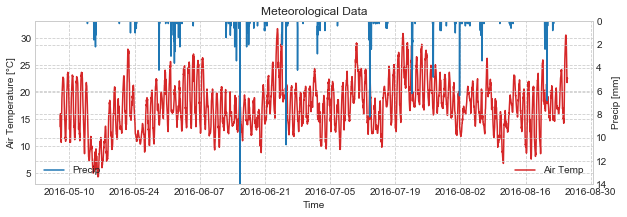

In [54]:
figsize(10,3)
tst=pd.to_datetime('2016-05-08')
ten=pd.to_datetime('2016-08-25')

tx=meteo.loc[tst:ten].copy()
fig, ax1 = plt.subplots()
ax1.plot(tx.index,tx['Air temperature [°C]'],'-',color=tableau10[3],label='Air Temp')
tx2=tx.resample('D').mean()
#ax1.plot(tx2.index,tx2.RH*0.4,'-',color=tableau10[2],label='RH')
#ax1.plot(tx2.index,tx2.u2*5.,'-',color=tableau10[2],label='Wind')
ax1.set_ylabel('Air Temperature [°C]')

ax2 = ax1.twinx()
ax2.plot(tx.index,tx['Precipitation [mm]'],color=tableau10[0],label='Precip')
ax2.set_ylim(14.,0.)
ax2.set_yticks(np.linspace(ax2.get_yticks()[0],ax2.get_yticks()[-1],len(ax1.get_yticks())))
ax2.set_ylabel('Precip [mm]')
ax1.set_xlabel('Time')

ax1.legend(loc=4,ncol=3)
ax2.legend(loc=3)
title('Meteorological Data')
#savefig('weather.pdf',bbox_inch='tight')

In [52]:
def theta_plot_shade(sens,shade,tst,ten,ll=1,lc=1):
    '''Plot monitoring data of volumetric soil water content as sensor groups with some sensors shaded
    sens :: sensor systems to be shown
    shade :: sensor systems to be shown shaded
    tst :: start time
    ten :: end time
    ll/lc :: legend location and number of columns
    '''
    MX=35.
    MN=3.
    for sensor in shade:
        idx=pd.Series(Theta20.columns.astype(str))[(Theta20sens==sensor)].values
        Tx=Theta20.loc[tst:ten,idx].copy()
        
        Tx[Tx>MX]=np.nan
        Tx[Tx<=MN]=np.nan
        
        #fill_between(Tx.index,Tx.median(axis=1)-0.5*Tx.std(axis=1),Tx.median(axis=1)+0.5*Tx.std(axis=1),color='silver',alpha=0.3)
        fill_between(Tx.index,Tx.quantile(axis=1)-0.5*Tx.std(axis=1),Tx.median(axis=1)+0.5*Tx.std(axis=1),color='silver',alpha=0.3)
        plot(Tx.index,Tx.median(axis=1),'-',color='silver')

    c=0.
    for sensor in sens:
        idx=pd.Series(Theta20.columns.astype(str))[(Theta20sens==sensor)].values
        Tx=Theta20.loc[tst:ten,idx].copy()
        kindofs='Volumetic Soil Water Content'
        unitlab='%'
        
        Tx[Tx>MX]=np.nan
        Tx[Tx<=MN]=np.nan
        
        fill_between(Tx.index,Tx.median(axis=1)-0.5*Tx.std(axis=1),Tx.median(axis=1)+0.5*Tx.std(axis=1),color=cm_t10(c),alpha=0.3)
        plot(Tx.index,Tx.median(axis=1),'-',color=cm_t10(c),label=sensor)
        c+=1./11.

    plot(Theta20.loc[tst:ten].index[:2],[MX*2,MX*2],'-',color='silver',label='other')
    title(''.join([kindofs,' [',unitlab,']']))
    xlabel('Time')
    ylabel(''.join([kindofs,' [',unitlab,']']))
    ylim(MN,MX)
    legend(loc=ll,ncol=lc)


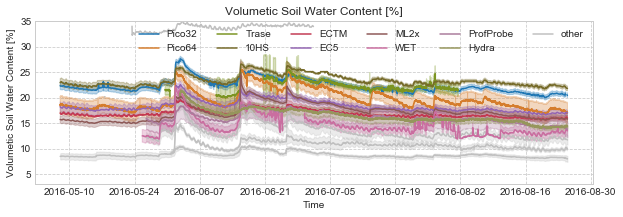

In [51]:
sensors=['Pico32', 'Pico64', 'Trase', '10HS', 'ECTM', 'EC5', 'ML2x', 'WET', 'ProfProbe', 'Hydra']
theta_plot_shade(sensors,['T3P', 'SMT', 'TOMST', 'TMS'],tst,ten,1,6)


In [57]:
def psi_plot_shade(sens,shade,tst,ten,ll=1,lc=1):
    '''Plot monitoring data of matrix potential as sensor groups with some sensors shaded
    sens :: sensor systems to be shown
    shade :: sensor systems to be shown shaded
    tst :: start time
    ten :: end time
    ll/lc :: legend location and number of columns
    '''
    MX=700.
    MN=1.

    for sensor in shade:
        idx=pd.Series(Psi20.columns.astype(str))[(Psi20sens==sensor)].values
        Tx=Psi20.loc[tst:ten,idx].copy()
        
        Tx[Tx>MX]=np.nan
        Tx[Tx<=MN]=np.nan
        
        fill_between(Tx.index,Tx.median(axis=1)-0.5*Tx.std(axis=1),Tx.median(axis=1)+0.5*Tx.std(axis=1),color='silver',alpha=0.3)
        plot(Tx.index,Tx.median(axis=1),'-',color='silver')
    
    c=0.    
    for sensor in sens:
        idx=pd.Series(Psi20.columns.astype(str))[(Psi20sens==sensor)].values
        Tx=Psi20.loc[tst:ten,idx].copy()
        kindofs='Matric Potential'
        unitlab='hPa'
        
        Tx[Tx>MX]=np.nan
        Tx[Tx<=MN]=np.nan
        
        fill_between(Tx.index,Tx.median(axis=1)-0.5*Tx.std(axis=1),Tx.median(axis=1)+0.5*Tx.std(axis=1),color=cm_t10(c),alpha=0.3)
        plot(Tx.index,Tx.median(axis=1),'-',color=cm_t10(c),label=sensor)
        c+=1./11.

    plot(Psi20.loc[tst:ten].index[:2],[MX*2,MX*2],'-',color='silver',label='other')
    title(''.join([kindofs,' [',unitlab,']']))
    xlabel('Time')
    ylabel(''.join([kindofs,' [',unitlab,']']))
    ylim(MN,MX)
    legend(loc=ll,ncol=lc)


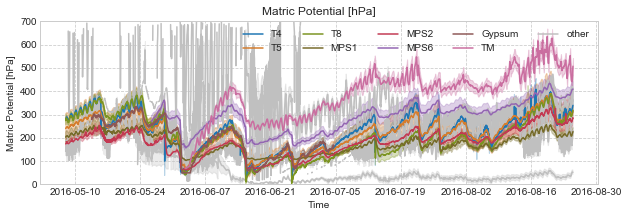

In [59]:
psi_plot_shade(['T4','T5','T8','MPS1','MPS2','MPS6','Gypsum','TM'],['POT','TS','SIS','HDis','pFMeter'],tst,ten,1,5)

In [60]:
def T_plot(sens,tst,ten,ll=1,lc=1):
    '''Plot monitoring data of soil temperature as sensor groups
    sens :: sensor systems to be shown
    tst :: start time
    ten :: end time
    ll/lc :: legend location and number of columns
    '''
    c=0.
    for sensor in sens:
        idx=pd.Series(T20.columns.astype(str))[(T20sens==sensor)].values
        Tx=T20.loc[tst:ten,idx].copy()
        kindofs='Soil Temperature'
        unitlab='°C'
        MX=42.
        MN=0.
        
        Tx[Tx>MX]=np.nan
        Tx[Tx<=MN]=np.nan
        
        fill_between(Tx.index,Tx.median(axis=1)-0.5*Tx.std(axis=1),Tx.median(axis=1)+0.5*Tx.std(axis=1),color=cm_t10(c),alpha=0.3)
        plot(Tx.index,Tx.median(axis=1),'-',color=cm_t10(c),label=sensor)
        c+=1./11.

    title(''.join([kindofs,' [',unitlab,']']))
    xlabel('Time')
    ylabel(''.join([kindofs,' [',unitlab,']']))
    ylim(MN,MX)
    legend(loc=ll,ncol=lc)

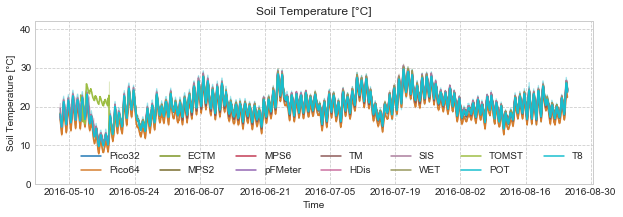

In [61]:
T_plot(['Pico32', 'Pico64', 'ECTM', 'MPS2', 'MPS6', 'pFMeter', 'TM', 'HDis','SIS', 'WET', 'TOMST', 'POT', 'T8'],tst,ten,4,7)

# EEMD Analysis

In [68]:
def rEEMD(tx,detect="parabol",graphx=False,s_break=15.):
    '''Wrapper for an Ensemble Empirical Mode Decomposition of a time series and 
    analysis of the frequency of the IMFs

    tx :: pandas time series input
    detect :: EEMD detection method
    s_break :: frequency (time steps) which bound seasonal from dirunal bands
    graphx :: graphical output if true
    '''
    from PyEMD import EEMD
    from scipy.signal import argrelextrema

    # check time series for nans and create consistent np.array
    # create mask to remove the introduced interpolation sequences in the resulting IMFs

    na_mask=False
    if any(pd.isnull(tx)):
        na_mask=np.where(pd.isnull(tx))[0]
        if pd.isnull(tx.iloc[0]):
            #extend series to first point if missing
            tx.iloc[0] = tx.iloc[np.where(~pd.isnull(tx))[0][0]]
        if pd.isnull(tx.iloc[-1]):
            #extend series to last point if missing
            tx.iloc[-1] = tx.iloc[np.where(~pd.isnull(tx))[0][-1]]

        tx = tx.interpolate()
    
    tx_data = tx.values
    tx_idx=(tx.index.to_julian_date()-tx.index.to_julian_date()[0]).values

    # Assign EEMD to `eemd` variable
    eemd = EEMD()

    # Say we want detect extrema using parabolic method
    emd = eemd.EMD
    emd.extrema_detection=detect

    # Execute EEMD on S
    eIMFs = eemd.eemd(tx_data, tx_idx)
    nIMFs = eIMFs.shape[0]
    
    if any(na_mask):
        for i in np.arange(nIMFs):
            eIMFs[i][na_mask]=np.nan
            
    eIMFsx = pd.DataFrame(eIMFs.T,index=tx.index)
    
    nIMFs = eIMFsx.shape[1]
    freq_s = np.zeros(nIMFs)
    lags = np.zeros((np.shape(eIMFsx)[1],48))
    #frequency and IMF analysis
    for i in np.arange(nIMFs):
        extr = argrelextrema(eIMFsx[i].values, np.greater)
        if len(extr[0])>1:
            freq_s[i] = np.timedelta64(np.median(eIMFsx.index[extr[0]].to_series().diff().values[1:]),'s').item().total_seconds()/3600.
        else:
            freq_s[i] = np.nan
            
        for j in np.arange(48):
            lags[i,j] = eIMFsx[i].autocorr(lag=j+1)
    
    freq_h = pd.Series(freq_s)
    freq_h.index = np.arange(nIMFs)
    
    lags = pd.DataFrame(lags.T)
    
    noise_check=pd.concat([lags.abs().median()<=0.05,
                           eIMFsx.mean(axis=0).abs()<=0.001,
                           (eIMFsx.var()-eIMFsx.rolling(200).var().median()).abs()<=0.001],axis=1)
    noise_check.columns=['insig.autocorr','zero.mean','const.var']
    noiseT = noise_check.sum(axis=1)==3
    freq_a = pd.concat([noise_check.sum(axis=1)==3,noise_check.sum(axis=1)==3,noise_check.sum(axis=1)==3,noise_check.sum(axis=1)==3],axis=1)
    freq_a.columns = ['Noise','Diurnal','Event','Offset/Season']
    freq_a['Diurnal'] = ((freq_a['Noise']==False) & (freq_h<=25.)).values
    freq_a['Event'] = ((freq_h>25.) & (freq_h<=s_break*24.)).values
    freq_a['Offset/Season'] = ((freq_h>s_break*24.) | ~(freq_h>0.)).values
    
    if graphx:
        figsize(16,3)
        for i in np.arange(4):
            subplot(1,4,i+1)
            dummy=eIMFsx.loc[:,freq_a.loc[freq_a[freq_a.columns[i]]].index].sum(axis=1)
            dummy.iloc[na_mask]=np.nan
            dummy.plot()
            title(freq_a.columns[i])
    
    return [eIMFsx,freq_a,freq_h]

def m_gof(results2,i=2):
    '''Collection of goodness of fit measures. Assumes multicore output given as results2.'''
    import itertools
    import errlib as el
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_mutual_info_score, mutual_info_score

    n=len(results2[0][0])
    r=np.arange(len(results2))

    gofs=pd.DataFrame(np.zeros((len(r),7)))
    gofs.columns=['RMSE','KGE','Kendall','Spearman','nMI','o','p']
    k=0
    for s in itertools.combinations(r, 2):
        #gofs.loc[k,'RMSE'] = np.linalg.norm(results2[s[0]][0].loc[:,results2[s[0]][1].loc[results2[s[0]][1][results2[s[0]][1].columns[i]]].index].sum(axis=1) - results2[s[1]][0].loc[:,results2[s[1]][1].loc[results2[s[1]][1][results2[s[1]][1].columns[i]]].index].sum(axis=1)) / np.sqrt(n)
        gofs.loc[k,'RMSE'] = np.sqrt(mean_squared_error(results2[s[0]][0].loc[:,results2[s[0]][1].loc[results2[s[0]][1][results2[s[0]][1].columns[i]]].index].sum(axis=1), results2[s[1]][0].loc[:,results2[s[1]][1].loc[results2[s[1]][1][results2[s[1]][1].columns[i]]].index].sum(axis=1)))
        gofs.loc[k,'KGE'] = el.KGE(results2[s[0]][0].loc[:,results2[s[0]][1].loc[results2[s[0]][1][results2[s[0]][1].columns[i]]].index].sum(axis=1).values,results2[s[1]][0].loc[:,results2[s[1]][1].loc[results2[s[1]][1][results2[s[1]][1].columns[i]]].index].sum(axis=1).values)[0]
        gofs.loc[k,'Kendall'] = sp.stats.kendalltau(results2[s[0]][0].loc[:,results2[s[0]][1].loc[results2[s[0]][1][results2[s[0]][1].columns[i]]].index].sum(axis=1).values,results2[s[1]][0].loc[:,results2[s[1]][1].loc[results2[s[1]][1][results2[s[1]][1].columns[i]]].index].sum(axis=1).values).correlation
        gofs.loc[k,'Spearman'] = sp.stats.mstats.spearmanr(results2[s[0]][0].loc[:,results2[s[0]][1].loc[results2[s[0]][1][results2[s[0]][1].columns[i]]].index].sum(axis=1).values,results2[s[1]][0].loc[:,results2[s[1]][1].loc[results2[s[1]][1][results2[s[1]][1].columns[i]]].index].sum(axis=1).values).correlation
        gofs.loc[k,'nMI'] = normalized_mutual_info_score(results2[s[0]][0].loc[:,results2[s[0]][1].loc[results2[s[0]][1][results2[s[0]][1].columns[i]]].index].sum(axis=1).values,results2[s[1]][0].loc[:,results2[s[1]][1].loc[results2[s[1]][1][results2[s[1]][1].columns[i]]].index].sum(axis=1).values)
        #gofs.loc[k,'nMI'] = adjusted_mutual_info_score(results2[s[0]][0].loc[:,results2[s[0]][1].loc[results2[s[0]][1][results2[s[0]][1].columns[i]]].index].sum(axis=1).values,results2[s[1]][0].loc[:,results2[s[1]][1].loc[results2[s[1]][1][results2[s[1]][1].columns[i]]].index].sum(axis=1).values)
        gofs.loc[k,'o'] = s[0]
        gofs.loc[k,'p'] = s[1]
        k+=1
        
    return gofs

def cor_mx_mult(mx_data,labl,ax,tit='Cor',mnmx=[0,1],cmapx='YlOrBr',showylab=True):
    import numpy as np
    import matplotlib.pyplot as plt
    from palettable.cartocolors.sequential import PinkYl_6
    from palettable.cartocolors.sequential import PinkYl_6_r
    import matplotlib.colors as colors
    
    N_points = len(mx_data)
    
    if tit=='RMSE':
        cmapx=PinkYl_6_r.mpl_colormap
        #cmapx='spring'
        ax.imshow(mx_data.T, interpolation='nearest',cmap=cmapx,vmin=mnmx[0],vmax=mnmx[1],norm=colors.PowerNorm(gamma=1./2.))
        
    if tit=='Season RMSE':
        cmapx=PinkYl_6_r.mpl_colormap
        #cmapx='spring'
        ax.imshow(mx_data.T, interpolation='nearest',cmap=cmapx,vmin=mnmx[0],vmax=mnmx[1],norm=colors.PowerNorm(gamma=1./2.))
    
    if tit=='Season Intercept':
        cmapx=PinkYl_6_r.mpl_colormap
        #cmapx='spring'
        ax.imshow(mx_data.T, interpolation='nearest',cmap=cmapx,norm=colors.PowerNorm(gamma=1./2.))
    
    if tit=='KGE':
        cmapx=PinkYl_6.mpl_colormap
        #cmapx='spring_r'
        #mnmx=[-30,1]
        ax.imshow(mx_data.T, interpolation='nearest',cmap=cmapx,vmin=mnmx[0],vmax=mnmx[1],norm=colors.PowerNorm(gamma=1./1.1))
        
    if tit=='Kendall':
        cmapx=PinkYl_6.mpl_colormap
        #cmapx='spring_r'
        mnmx=[0.3,0.95]
        ax.imshow(mx_data.T, interpolation='nearest',cmap=cmapx,vmin=mnmx[0],vmax=mnmx[1],norm=colors.PowerNorm(gamma=1./1.1))
        
    if tit=='Spearman':
        cmapx=PinkYl_6.mpl_colormap
        #cmapx='spring_r'
        mnmx=[0.3,0.95]
        ax.imshow(mx_data.T, interpolation='nearest',cmap=cmapx,vmin=mnmx[0],vmax=mnmx[1],norm=colors.PowerNorm(gamma=1./1.1))
    
    if tit=='nMI':
        cmapx=PinkYl_6.mpl_colormap
        #cmapx='spring_r'
        mnmx=[0.5,1.0]
        ax.imshow(mx_data.T, interpolation='nearest',cmap=cmapx,vmin=mnmx[0],vmax=mnmx[1],norm=colors.PowerNorm(gamma=1./1.1))

    
    #text portion
    ind_array = np.arange(len(mx_data))
    x, y = np.meshgrid(ind_array, ind_array)

    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = np.round(mx_data[int(x_val),int(y_val)],2)
        if ~(abs(c)>=0):
            c=''
        ax.text(x_val, y_val, c, va='center', ha='center')

    #set tick marks for grid
    ax.set_xticks(np.arange(0., N_points))
    ax.set_yticks(np.arange(0., N_points))
    ax.set_xticklabels(labl[:-1])
    if showylab:
        ax.set_yticklabels(labl[1:])
    else:
        ax.set_yticklabels([])
    ax.grid()
    ax.set_xlim(-0.5, N_points-0.5)
    ax.set_ylim(-0.5, N_points-0.5)
    ax.set_title(tit)

def cor_plot_x3(results2,sen,savef=False):
    '''Plot the results of the EEMD. Assumes multicore output given as results2.
    '''
    import matplotlib.gridspec as gridspec
    from palettable.cartocolors.qualitative import Vivid_10#Bold_8
    
    G = gridspec.GridSpec(2, 20)

    figsize(14,8)
    for i in np.arange(4):
        #subplot(1,4,i+1)
        subplot(G[0, i*5:(i+1)*5])
        for j in np.arange(len(results2)):
            if len(results2[j][1].loc[results2[j][1][results2[j][1].columns[i]]].index)>1:
                dummy=results2[j][0].loc[:,results2[j][1].loc[results2[j][1][results2[j][1].columns[i]]].index].sum(axis=1)
                if any(pd.isnull(results2[j][0].loc[:,results2[j][1].loc[results2[j][1][results2[j][1].columns[i]]].index[0]])):
                    na_mask=pd.isnull(results2[j][0].loc[:,results2[j][1].loc[results2[j][1][results2[j][1].columns[i]]].index[0]])
                    dummy.loc[na_mask]=np.nan
            else:
                dummy=results2[j][0].loc[:,results2[j][1].loc[results2[j][1][results2[j][1].columns[i]]].index]
                
            try:
                plot(dummy,color=Vivid_10.mpl_colors[j],label=sen[j])
            except:
                print('WARNING: No '+results2[j][1].columns[i]+' data at '+sen[j])
        title(results2[j][1].columns[i])
        xticks(rotation=70)
        
    legend(loc=3,ncol=2)
    
    #event
    resx=m_gof(results2,2)
    m = len(resx.columns)-3
    n = len(sen)
    
    showylab=True
    j=0
    for i in np.array([0,2,1,4]):
        mx=np.zeros((n,n))*np.nan
        mx[resx.o.values.astype(int),resx.p.values.astype(int)]=resx[resx.columns[i]].values
        cor_mx_mult(mx[:-1,1:],sen,subplot(G[1, j*4:(j+1)*4]),resx.columns[i],showylab=showylab)
        showylab=False
        j+=1
    #season
    resy=m_gof(results2,3)
    mx=np.zeros((n,n))*np.nan
    mx[resy.o.values.astype(int),resy.p.values.astype(int)]=resy['RMSE'].values
    cor_mx_mult(mx[:-1,1:],sen,subplot(G[1, 4*4:]),'Season RMSE',showylab=showylab)
        
    plt.tight_layout()
    if savef:
        plt.savefig(savef,bbox_inches='tight')
    plt.show()
    

In [64]:
t_start=pd.to_datetime('2016-05-20 00:00')
t_end=pd.to_datetime('2016-07-20 00:00')

import multiprocessing
pool = multiprocessing.Pool()

In [65]:
#run multicore EEMD of Pico32 TDR data as example
results = pool.map(rEEMD, [Theta20.loc[t_start:t_end,'Pico321'],Theta20.loc[t_start:t_end,'Pico322'],Theta20.loc[t_start:t_end,'Pico323'],Theta20.loc[t_start:t_end,'Pico324']])

In [66]:
#run multicore EEMD of Pico32, ECTM, ML2x and WET sensor groups as example
results2 = pool.map(rEEMD, [Theta20.loc[t_start:t_end,Theta20.columns[np.where(Theta20sens=='Pico32')[0]+1]].mean(axis=1),
                            Theta20.loc[t_start:t_end,Theta20.columns[np.where(Theta20sens=='ECTM')[0]+1]].mean(axis=1),
                            Theta20.loc[t_start:t_end,Theta20.columns[np.where(Theta20sens=='ML2x')[0]+1]].mean(axis=1),
                           Theta20.loc[t_start:t_end,Theta20.columns[np.where(Theta20sens=='WET')[0]+1]].mean(axis=1)])

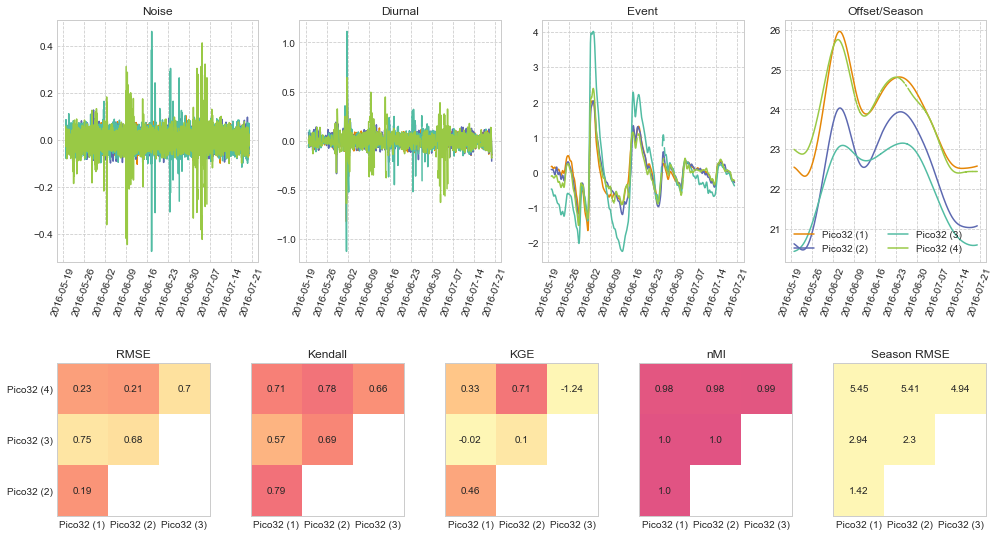

In [69]:
cor_plot_x3(results,['Pico32 (1)','Pico32 (2)','Pico32 (3)','Pico32 (4)'])#,'pico32_eemd.pdf')

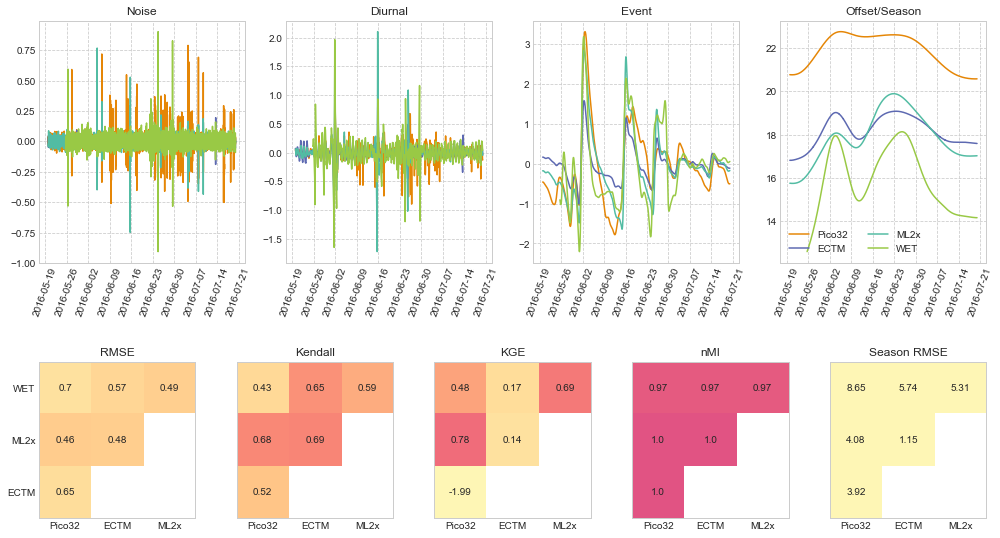

In [70]:
cor_plot_x3(results2,['Pico32','ECTM','ML2x','WET'])#,'theta_eemd.pdf')

In [71]:
m_gof(results2,3)

,RMSE,KGE,Kendall,Spearman,nMI,o,p
0,3.917957,0.338125,0.629306,0.809021,0.999644,0.0,1.0
1,4.079098,0.507196,0.533855,0.692071,1.000000,0.0,2.0
2,8.646933,-0.060078,0.645854,0.830461,0.967134,0.0,3.0
3,1.145298,0.531281,0.815804,0.929575,0.999644,1.0,2.0
4,5.743030,0.028235,0.918211,0.985384,0.966743,1.0,3.0
5,5.306146,0.163151,0.773108,0.905605,0.967134,2.0,3.0


# Lab monolite reference

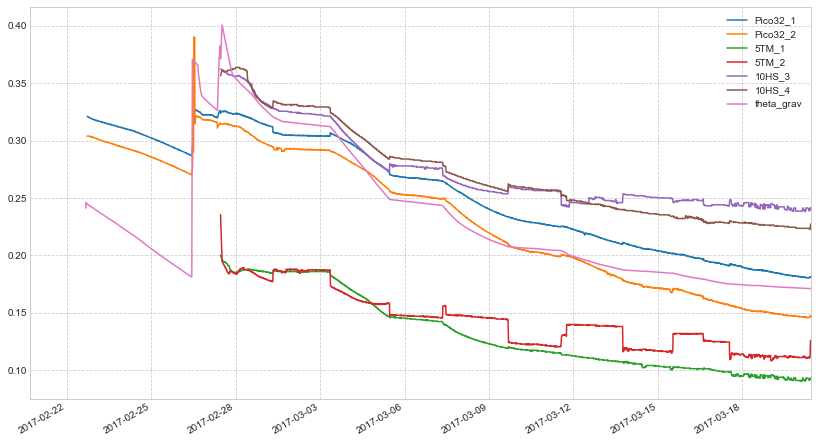

In [74]:
labmono=pd.read_csv('lab_mono.csv',index_col='Time')
labmono.index=pd.to_datetime(labmono.index.values)
labmono.plot()